In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

import time

import numpy as np
import struct
import os

import pandas as pd

SEED=3

### 1. Load and Prepare Data

First, load the dataset and prepare in for SK Learn. Read and prepare are done in the **read** function. The **show** function plots a given image as a quick sanity check. For the first part of this assignment, we work with only the digits 4 and 9 so the dataset is filtered to these images only.

In [2]:
# The code below was adapted from: https://gist.github.com/akesling/5358964

def read(dataset = "training", path = ".", digits=[]):
    """
    Python function for importing the MNIST data set.  It returns two Numpy array
    one with flattened feature vectors and one with the label of the digit.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    data = []
    for i in range(len(lbl)):
        data.append(get_img(i))
    
    X = []
    y = []

    for digit, data in filter(lambda x: x[0] in digits, data):
        X.append(data.flatten())
        y.append(digit)
        
    return np.array(X), np.array(y)
            

def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

In [21]:
digits = [4, 9]
X, y  = read(dataset = "training", path = ".", digits=digits)
X_test, y_test  = read(dataset = "testing", path = ".", digits=digits)

print("Training data")
print("Data shape: ", X.shape)
for digit in digits:
    print("Count {} = {}".format(digit, len(list(filter(lambda x: x == digit, y)))))
    
print("\nTesting data")
print("Data shape: ", X_test.shape)
for digit in digits:
    print("Count {} = {}".format(digit, len(list(filter(lambda x: x == digit, y_test)))))

Training data
Data shape:  (11791, 784)
Count 4 = 5842
Count 9 = 5949

Testing data
Data shape:  (1991, 784)
Count 4 = 982
Count 9 = 1009


#### Plot some examples

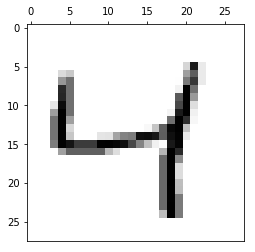

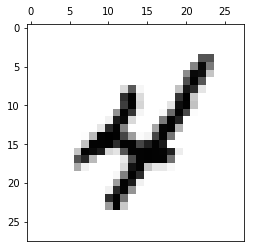

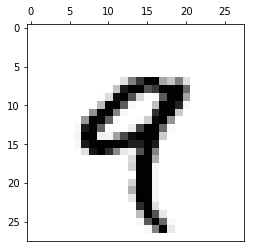

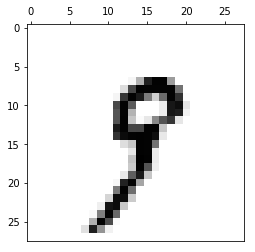

In [5]:
show(X[0].reshape((28, 28)))
show(X[2].reshape((28, 28)))
show(X[1].reshape((28, 28)))
show(X[3].reshape((28, 28)))

### 2. Model Fitting for Parameter Exploration

The primary goal of this paper is to explore the fitting complexity and classification performence of three kernels - the Linear kernel, Polynomial kernel, and Radial-Basis-Function kernel. In order to get a quick and accurate picture of how the three kernels perform, we use a cross-validated grid search. This is a succinct and powerful way to try a variety of different parametrizations for an SKLearn SVM, with repetition, and then collect all relevant statistics - training time, train score, CV test score etc. Given I have no prior intuition on which kernel is actually best, or which parameters will be optimal, this is the fastest way to 'try all theories'.

In the configuration below, we define 3 parameter spaces. The grid search tries every combination of the application parameters for each kernel, running a 3-fold cross-validation.
 - The **Penalty parameter (C) range** is 6 digits between $10^{-4}$ and $10^{1}$ with a value at each order of magnitude. This parameter applies to all three kernels.
 
 
 - The **Gamma parameter range** is 10 digits between $10^{-8}$ and $1$  with a value at each order of magnitude. This is only used for the Polynomial and RBF kernels.
 
 
 - The **Degree parameter range** is 3 digits: $\{2, 3, 4\}$ and is only used for the Polynomial kernel.

Before running the grid search, we reduce the dataset size using the SKLearn train_test_split function. This is done to allow for a quick search of the full parameter space - which involves approximately 800 fits. The split is set to select a random 3000 training examples and a further 500 test examples. The test examples are irrelevant given there is a provided test set. The new train set is around 25% of the original 11791 images. It is important to note that the class labels vector is passed to the stratify argument on train_test_split to ensure that both the train set (and the test set) maintain the proportion of the digit classes in the original data - which is around 50% for 4 and 9.

The grid search is then run on the training examples. The 3-fold CV means that each fit is done with $n = 2000$. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=3000, 
                                                    test_size=500, random_state=SEED, stratify=y)
X_train.shape

(3000, 784)

In [7]:
%%time

svc_pipe = Pipeline(
    [
        ('classify', SVC(random_state=SEED))
    ])

gamma_range = np.logspace(-8, 0, 8)
C_range = np.logspace(-4, 1, 6)

param_grid = [
    {
        'classify__kernel': ['rbf'],
        'classify__C': C_range,
        'classify__gamma': gamma_range
    },
    {
        'classify__kernel': ['poly'],
        'classify__C': C_range,
        'classify__gamma': gamma_range,
        'classify__degree': [2, 3, 4],
        
    },
    {
        'classify__kernel': ['linear'],
        'classify__C': C_range
    },
]


svc_grid = GridSearchCV(svc_pipe, cv=3, n_jobs=-1,
                        param_grid=param_grid, verbose=1, return_train_score=True)

svc_grid.fit(X_train, y_train)

print(svc_grid.best_params_, svc_grid.best_score_)

Fitting 3 folds for each of 198 candidates, totalling 594 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 594 out of 594 | elapsed:  5.6min finished


{'classify__C': 0.1, 'classify__degree': 2, 'classify__gamma': 1.9306977288832498e-06, 'classify__kernel': 'poly'} 0.979
CPU times: user 5.63 s, sys: 218 ms, total: 5.85 s
Wall time: 5min 35s


### 3. Analysis of Parameter Exploration Results:

First, we provide code to extract summary statistics from the CV grid. This code is run to provide The average, min and max for the mean test score, mean train score and mean fit time. Here, 'mean' refers to the mean of the 3 CV runs per parameter configuration. The full results are displayed below. 

It is clear from the results that the Polynomial kernel and the RBF are similar in CV test-accuracy, with both scoring a maximum of around 98% with their best parameters. The polynomial confers a significant timing advantage, with the average fit time for n=2000 being 2.829 seconds vs 7.244 seconds for the RBF kernel (~2x shorter). It is important to note that the range (defined by the max/min fit time) is actually very similar for both kernels. And, further, the fit time for the best Polynomial is 1.384 seconds while for the best 1.573 seconds. So, in range and fit time for the best params, the two Kernels are very similar. More exploration of fit time/scaling will be done in section 5.

It is also interesting to note that the Polynomial kernel appears more *robust* to parameter settings. The mean cv-test accuracy for the Polynomial kernel is 0.89, with min 0.505 and max 0.979 while the mean for the RBF is 0.581 with min 0.505 and max 0.978. So, it appears the Polynomial kernel has a left tail while the RBF has a right tail.

These results, both in terms of fit time and score ranges, make some sense: the RBF has significantly more freedom in the functional form it models. IE, it has more capacity for functional variability. With 'incorrect' settings, it may be far to simple/complex and thus do a poor job separating the data (plus have a long training time). However, with good parameters it can do as well, if not better than, the Polynomial kernel which is essentially a 'special case' of the RBF. By this logic, the Polynomial kernel does a decent job regardless of parameterization because the form is constrained to one which always decently separating the data. In fact, it would appear that the RBF kernel will *always* perform as well as or better than the Polynomial kernel under optimal settings because, as above, the Polynomial kernel is basically a special case of the RBF. By extension, in cases where the function is slightly different from polynomial, the RBF may be able to adjust just enough to fit better. Further work is required to verify this posulations. 

Finally, it is worth noting that the linear kernel has a maximum score of 0.945 with an average fit time of 1 second. This is decent results in 3x less time than the Polynomial kernel. This may be useful if we prioritize training cost over perfect accuracy. However, we will see that this result does not generalize well in the next section.

In [8]:
results = svc_grid.cv_results_
results_data = pd.DataFrame.from_dict(results)
results_data.to_csv("results_1.csv")
results_data.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__C,param_classify__degree,param_classify__gamma,param_classify__kernel,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,7.508348,3.448900,0.504667,0.504667,0.0001,NaN,1e-08,rbf,"{'classify__C': 0.0001, 'classify__gamma': 1e-...",137,0.504496,0.504752,0.505,0.5045,0.504505,0.504748,0.025993,0.059709,0.000236,0.000118
1,7.303214,3.561730,0.504667,0.504667,0.0001,NaN,1.3895e-07,rbf,"{'classify__C': 0.0001, 'classify__gamma': 1.3...",137,0.504496,0.504752,0.505,0.5045,0.504505,0.504748,0.041617,0.022732,0.000236,0.000118
2,7.243295,3.549647,0.504667,0.504667,0.0001,NaN,1.9307e-06,rbf,"{'classify__C': 0.0001, 'classify__gamma': 1.9...",137,0.504496,0.504752,0.505,0.5045,0.504505,0.504748,0.036736,0.030227,0.000236,0.000118
3,7.269330,3.540244,0.504667,0.504667,0.0001,NaN,2.6827e-05,rbf,"{'classify__C': 0.0001, 'classify__gamma': 2.6...",137,0.504496,0.504752,0.505,0.5045,0.504505,0.504748,0.055840,0.023172,0.000236,0.000118
4,7.161787,3.497110,0.504667,0.504667,0.0001,NaN,0.000372759,rbf,"{'classify__C': 0.0001, 'classify__gamma': 0.0...",137,0.504496,0.504752,0.505,0.5045,0.504505,0.504748,0.050968,0.023813,0.000236,0.000118


In [9]:
# Extract summary results from the gird search results.

def get_field_summary(field, split_param, split_param_value, verbose=True, decimals=3):
    '''
    Output the average, min, max for a given field in SKLearn
    GridSearch results, filtering on any field/values. Optionally
    output the parameters which maximize the field.
    '''
    
    values = []
    first = None
    
    for i, result in enumerate(svc_grid.cv_results_[field]):
        
        if svc_grid.cv_results_["params"][i][split_param] == split_param_value:
            if first is None:
                first = i
                
            values.append(result)
    
    average = np.round(np.mean(values), decimals)
    maxi, mini = np.round(np.max(values), decimals), np.round(np.min(values), decimals)
    index_maxi, index_mini = np.argmax(values), np.argmin(values)
    
    if verbose:
        print("Average '{}' for '{}={}' is: {}".format(field, split_param, split_param_value, average))
        print("Max/Min '{}' for '{}={}' are: {}/{}".format(field, split_param, split_param_value, maxi, mini))
        
    if verbose == 2: 
        print("Best Params: {}".format(svc_grid.cv_results_["params"][first + index_maxi]))
        print("Time for best: {}".format(np.round(svc_grid.cv_results_["mean_fit_time"][first + index_maxi], decimals)))


#### Results Output

In [10]:
data_fields = {"mean_test_score": 2, "mean_train_score": 2, "mean_fit_time": 1}
levels_info = {
    "classify__kernel": {"levels": ["poly", "rbf", "linear"], "name": "Kernel"}
}

for field, field_info in levels_info.items():
    print("Summary for {} field:\n------------\n".format(field_info["name"]))
    for level in field_info["levels"]:
        print("{}={}:\n".format(field_info["name"], level))
        for data_field, verbosity in data_fields.items():
            get_field_summary(data_field, field, level, verbose=verbosity)
            print("\n")
        print("------\n")

Summary for Kernel field:
------------

Kernel=poly:

Average 'mean_test_score' for 'classify__kernel=poly' is: 0.89
Max/Min 'mean_test_score' for 'classify__kernel=poly' are: 0.979/0.505
Best Params: {'classify__C': 0.1, 'classify__degree': 2, 'classify__gamma': 1.9306977288832498e-06, 'classify__kernel': 'poly'}
Time for best: 1.384


Average 'mean_train_score' for 'classify__kernel=poly' is: 0.908
Max/Min 'mean_train_score' for 'classify__kernel=poly' are: 1.0/0.505
Best Params: {'classify__C': 0.0001, 'classify__degree': 2, 'classify__gamma': 0.0003727593720314938, 'classify__kernel': 'poly'}
Time for best: 1.378


Average 'mean_fit_time' for 'classify__kernel=poly' is: 2.829
Max/Min 'mean_fit_time' for 'classify__kernel=poly' are: 7.862/1.209


------

Kernel=rbf:

Average 'mean_test_score' for 'classify__kernel=rbf' is: 0.581
Max/Min 'mean_test_score' for 'classify__kernel=rbf' are: 0.978/0.505
Best Params: {'classify__C': 10.0, 'classify__gamma': 1.389495494373136e-07, 'classify

### 4. Performence Analysis for Best Parameters

We now fit the best parameters for the RBF and Polynomial kernels on the full dataset and then use the MNIST test set to rate their performence.

The RBF kernel achieves an accuracy score of 0.991 (or an error rate of 0.95%) with a fit time of 11.54 seconds. The Polynomial kernel achieves an accuracy score of 0.988 (or an error rate of 1.15%) with a fit time of 10.332 seconds. Firstly, this appears to confirm the intuition that at optimal settings, the RBF kernel will outperform the Polynomial kernel due to it's slightly more flexible form. Although it must be said that these results are very similar. Second, it is worth noting that these results are in line with the error rates reported by Ya LeCunn which are 1.4% for an SVM with an RBF Kernel and 1.1% for a Polynomial kernel (although his parameterization is different). The classification report for both models reveals no meaningful false positive/negative dynamic. The fit times for a 4x increase in data have increased by around 10x, this is explored in the next section.

The fit for the linear kernel shows a significantly worse fit time performence than indicated in the CV, with the fit taking ~30 seconds. We can no longer be so certain that this model will be useful when computation is expensive.  

In [35]:
poly_best_params = {'C': 0.1, 'degree': 2, 'gamma': 1.9306977288832498e-06, 'kernel': 'poly'}
rbf_best_params = {'C': 10.0, 'gamma': 1.389495494373136e-07, 'kernel': 'rbf'}
linear_best_params = {'C': 0.0001, 'kernel': 'linear'}

params = {
    "Polynomial": poly_best_params,
    "RBF": rbf_best_params,
    "Linear": linear_best_params
}

for kernel, param in params.items():
    svc = SVC(random_state=SEED, **param)
    
    start = time.time()
    svc.fit(X, y)
    fit_time = time.time() - start
    
    predictions = svc.predict(X_test)
    
    accuracy = accuracy_score(predictions, y_test)
    
    
    print("{} kernel".format(kernel))
    print("Fit time for n={}: {} seconds".format(X.shape[0], fit_time))
    print("Accuracy: {}".format(accuracy))
    print(classification_report(predictions, y_test))
    print("-------------")



Polynomial kernel
Fit time for n=11791: 10.353140115737915 seconds
Accuracy: 0.9884480160723255
             precision    recall  f1-score   support

          4       0.99      0.99      0.99       985
          9       0.99      0.99      0.99      1006

avg / total       0.99      0.99      0.99      1991

-------------
RBF kernel
Fit time for n=11791: 11.55987000465393 seconds
Accuracy: 0.9909593169261678
             precision    recall  f1-score   support

          4       0.99      0.99      0.99       980
          9       0.99      0.99      0.99      1011

avg / total       0.99      0.99      0.99      1991

-------------
Linear kernel
Fit time for n=11791: 30.060826778411865 seconds
Accuracy: 0.9653440482169764
             precision    recall  f1-score   support

          4       0.97      0.96      0.96       985
          9       0.96      0.97      0.97      1006

avg / total       0.97      0.97      0.97      1991

-------------


### 5. Scaling Behavior

The final exploration focuses on scaling behaviour for the three kernels. In order to establish this, we use the same dataset reduction method as above, using test_train_split from SKLearn. We run a fit five times for 8 dataset sizes on a log scale between n=100 and n=10000 collecting mean fit time, predict time, and accuracy score. The accuracy is always tested using 1000 data points. The fit time is plotted log-log and a linear fit is run. The accuracy is plotted on a semi-log with dataset size logged.

The linear relationship on the log-log plots show that the RBF and Polynomial both have polynomial scaling behaviour with very similar polynomial powers of ~1.5. It appears that both kernels experience logarithmic gains from more data with gains slowing as the accuracy approaches 1. The Linear kernel also appears to have polynomial complexity but with a higher coefficient of ~1.8. Both its scaling and accuracy gains are less regular than the other two kernels. It is unclear what exactly drives this behaviour but it is probably the fact that a model which fits the data relatively poorly will get haphazard gains with increased data.

In [40]:
def svc_runner(n, clf_kwargs):
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=n, test_size=1000)

    if len(clf_kwargs)==0:
        clf = SVC(C=1.0, kernel='rbf', gamma='auto')
    else:
        clf = SVC(**clf_kwargs)

    train_start = time.time()
    clf.fit(x_train, y_train)
    train_time = time.time() - train_start
    
    classify_start = time.time()
    y_pred = clf.predict(x_test)
    classify_time = time.time() - classify_start
    
    score = accuracy_score(y_pred, y_test)
    
    return (train_time, classify_time, score)

def test_battery(n_levels, trials=5, clf_kwargs={}):
    results = []
    for n_level in n_levels:
        print("Running with n={}".format(int(n_level)))
        trial_results = []
        for i in range(trials):
            train_time, classify_time, score = svc_runner(int(n_level), clf_kwargs=clf_kwargs)
            trial_results.append([train_time, classify_time, score])
        
        print("Done {} trials".format(trials))
        
        results.append(np.sum(trial_results, axis=0)/float(trials))
    
    return np.array(results)

Polynomial Kernel

Running with n=100
Done 5 trials
Running with n=193
Done 5 trials
Running with n=372
Done 5 trials
Running with n=719
Done 5 trials
Running with n=1389
Done 5 trials
Running with n=2682
Done 5 trials
Running with n=5179
Done 5 trials
Running with n=10000
Done 5 trials


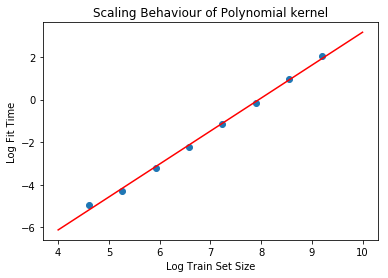

Log-log scaling coefficient: 1.5451462980042183


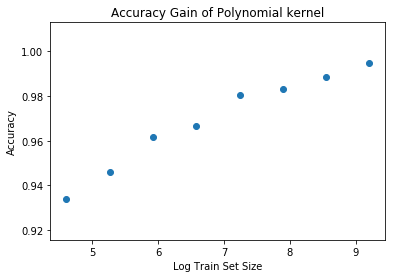

-------------
RBF Kernel

Running with n=100
Done 5 trials
Running with n=193
Done 5 trials
Running with n=372
Done 5 trials
Running with n=719
Done 5 trials
Running with n=1389
Done 5 trials
Running with n=2682
Done 5 trials
Running with n=5179
Done 5 trials
Running with n=10000
Done 5 trials


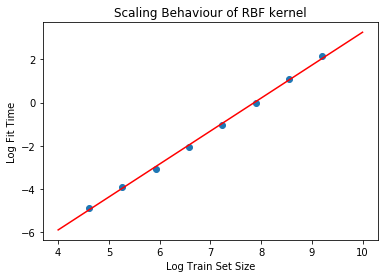

Log-log scaling coefficient: 1.5264319224615388


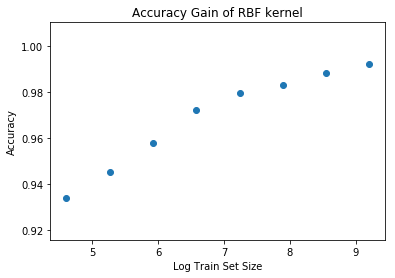

-------------
Linear Kernel

Running with n=100
Done 5 trials
Running with n=193
Done 5 trials
Running with n=372
Done 5 trials
Running with n=719
Done 5 trials
Running with n=1389
Done 5 trials
Running with n=2682
Done 5 trials
Running with n=5179
Done 5 trials
Running with n=10000
Done 5 trials


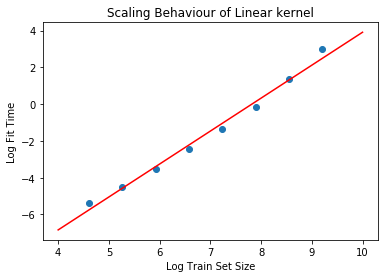

Log-log scaling coefficient: 1.7923528593176477


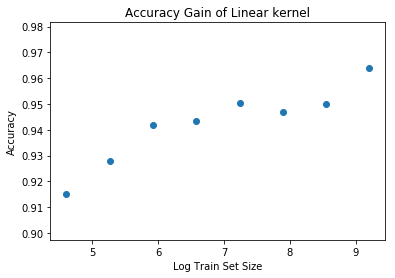

-------------


In [58]:
levels = np.logspace(2, 4, 8)
xs = np.linspace(4, 10, 100)

for kernel, param in params.items():
    print("{} Kernel\n".format(kernel))
    
    print("Collecting results:")
    results = test_battery(levels, clf_kwargs=param)
    
    plt.scatter(np.log(levels), np.log(results[:, 0]))
    plt.title("Scaling Behaviour of {} kernel".format(kernel))
    plt.ylabel("Log Fit Time")
    plt.xlabel("Log Train Set Size")
    coeffs = np.polyfit(np.log(levels), np.log(results[:, 0]), deg=1)
    plt.plot(xs, coeffs[0]*xs + coeffs[1], c="red")
    plt.show()
    print("Log-log scaling coefficient: {}".format(coeffs[0]))
    
    
    plt.scatter(np.log(levels), results[:, 2])
    plt.title("Accuracy Gain of {} kernel".format(kernel))
    plt.ylabel("Accuracy")
    plt.xlabel("Log Train Set Size")
    plt.show()

    print("-------------")